In [1]:
import cupy as cp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from Network import Network

In [22]:
train_X = cp.load("./data/train_images.npy") / 255
train_y = cp.load("./data/train_labels.npy").astype(int).flatten()
test_X = cp.load("./data/test_images.npy") / 255
test_y = cp.load("./data/test_labels.npy").astype(int).flatten()

print(f"train_X.shape: {train_X.shape}")
print(f"train_y.shape: {train_y.shape}")
print(f"test_X.shape: {test_X.shape}")
print(f"test_y.shape: {test_y.shape}")

train_X.shape: (60000, 784)
train_y.shape: (60000,)
test_X.shape: (10000, 784)
test_y.shape: (10000,)


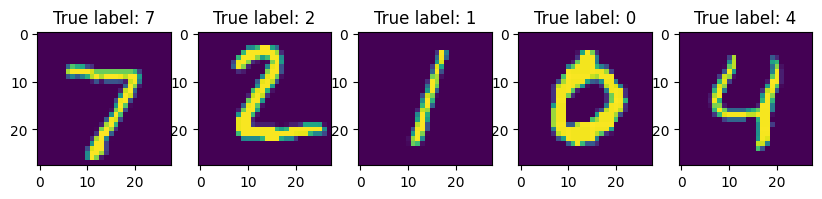

In [23]:
n_plots = 5
fig, axs = plt.subplots(1, n_plots, figsize=(n_plots*2, 2))
for i in range(n_plots):
    axs[i].set_title(f"True label: {test_y[i]}")
    axs[i].imshow(test_X[i].reshape((28, 28)).get())

In [24]:
nn = Network(784, 10, [20, 15, 10])
n_params = 0
for layer in nn.layers:
    n_params += layer.weights.size + layer.biases.size
print(f"{n_params} parameters.")

print(f"prediction on first example:")
print(nn(train_X[:1]))

# Regularization term
lambda_ = 0

print(f"Initial loss:          {nn.loss(train_X, train_y):.5f}")
print(f"Initial accuracy:      {nn.accuracy(train_X, train_y):.5f}")

print(f"Initial test loss:     {nn.loss(test_X, test_y):.5f}")
print(f"Initial test accuracy: {nn.accuracy(test_X, test_y):.5f}")

16285 parameters.
prediction on first example:
[[0.         0.         0.38375995 0.3505673  0.61180274 0.
  0.         0.         0.30466153 0.55247104]]
Initial loss:          2.33963
Initial accuracy:      0.11325
Initial test loss:     2.30249
Initial test accuracy: 0.12100


In [25]:
def training_epoch(train_X, train_y, lr=1e-3, batch_size=30, verbose=False):
    """
    verbose - if True, use a tqdm progress bar
    """
    iterable = range(len(train_X) // batch_size)

    if verbose:
        iterable = tqdm(iterable)

    for batch_idx in iterable:
        X = train_X[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        y = train_y[batch_idx * batch_size:(batch_idx + 1) * batch_size]

        nn.compute_grads(X, y, lambda_=lambda_)
        nn.update_params(alpha=lr)

        loss = nn.loss(X, y)
        acc = nn.accuracy(X, y)

        if verbose:
            iterable.set_description(f"loss: {loss:.4f} - acc: {acc:.4f}")

In [26]:
TRAIN_LOSS_HIST = []
TRAIN_ACC_HIST = []
TEST_LOSS_HIST = []
TEST_ACC_HIST = []

In [27]:
def train_iteration(epochs, lr, batch_size=500):
    for epoch in range(epochs):
        TRAIN_LOSS_HIST.append(nn.loss(train_X, train_y))
        TRAIN_ACC_HIST.append(nn.accuracy(train_X, train_y))
        TEST_LOSS_HIST.append(nn.loss(test_X, test_y))
        TEST_ACC_HIST.append(nn.accuracy(test_X, test_y))
        training_epoch(train_X, train_y, lr=lr, batch_size=batch_size, verbose=True)
        print(f"Epoch {epoch:>2}: loss={TRAIN_LOSS_HIST[-1]:.3f}, acc={TRAIN_ACC_HIST[-1]:.3f}, test loss={TEST_LOSS_HIST[-1]:.3f}, test acc={TEST_ACC_HIST[-1]:.3f}")
    
    TRAIN_LOSS_HIST.append(nn.loss(train_X, train_y))
    TRAIN_ACC_HIST.append(nn.accuracy(train_X, train_y))
    TEST_LOSS_HIST.append(nn.loss(test_X, test_y))
    TEST_ACC_HIST.append(nn.accuracy(test_X, test_y))

In [28]:
train_iteration(epochs=2, lr=1e-2, batch_size=500)

loss: 2.6243 - acc: 0.8520: 100%|██████████| 120/120 [00:01<00:00, 85.94it/s]


Epoch  0: loss=2.340, acc=0.113, test loss=2.302, test acc=0.121


loss: 2.7480 - acc: 0.8660: 100%|██████████| 120/120 [00:01<00:00, 91.54it/s]


Epoch  1: loss=3.072, acc=0.826, test loss=2.594, test acc=0.114


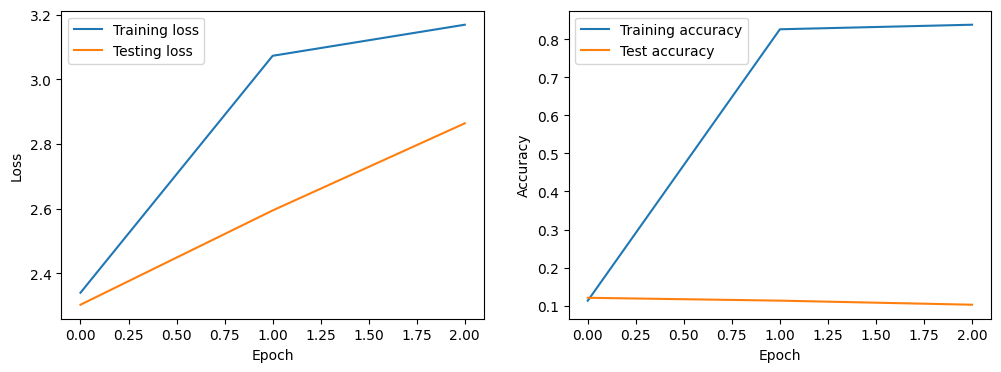

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(TRAIN_LOSS_HIST, label="Training loss")
axs[0].plot(TEST_LOSS_HIST, label="Testing loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend();
axs[1].plot(TRAIN_ACC_HIST, label="Training accuracy")
axs[1].plot(TEST_ACC_HIST, label="Test accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend();

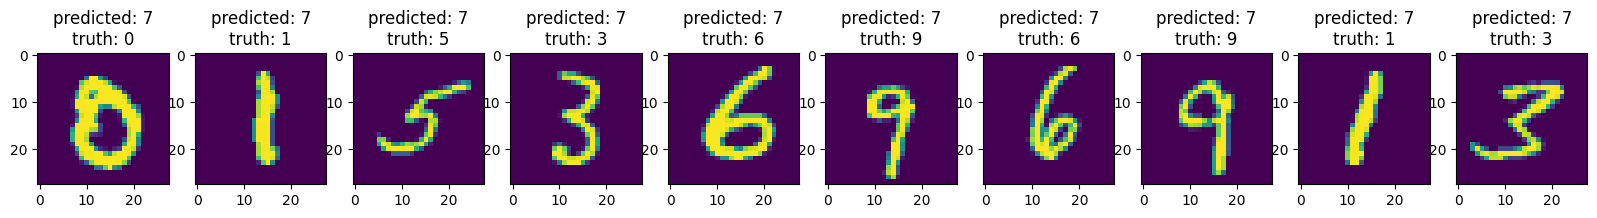

In [30]:
# Look at misidentified digits
y_pred = nn.predict(test_X)
wrong_indices = np.where(y_pred != test_y.get())[0]

def display_digit(img, title, ax):
    img = img.reshape((28, 28))
    ax.imshow(img)
    ax.set_title(title)

fig, axs = plt.subplots(1, 10, figsize=(20, 4))

np.random.shuffle(wrong_indices)
for i in range(10):
    idx = wrong_indices[i]
    display_digit(test_X.get()[idx], f"predicted: {y_pred[idx]}\ntruth: {test_y.get()[idx]}", axs[i])

Final loss:     2.8635
Final accuracy: 0.1028


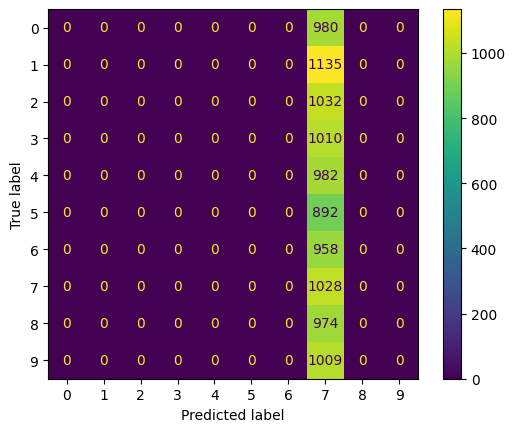

In [31]:
conf_mat = confusion_matrix(test_y.get(), nn.predict(test_X), labels=range(10))
disp = ConfusionMatrixDisplay(conf_mat);
disp.plot();

print(f"Final loss:     {nn.loss(test_X, test_y):.4f}")
print(f"Final accuracy: {nn.accuracy(test_X, test_y):.4f}")

Final loss:     3.1684
Final accuracy: 0.8377


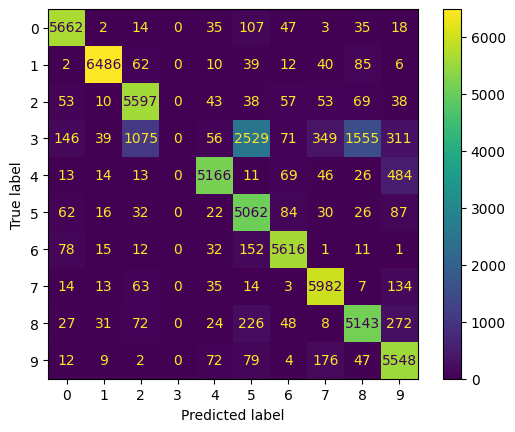

In [32]:
conf_mat = confusion_matrix(train_y.get(), nn.predict(train_X), labels=range(10))
disp = ConfusionMatrixDisplay(conf_mat);
disp.plot();

print(f"Final loss:     {nn.loss(train_X, train_y):.4f}")
print(f"Final accuracy: {nn.accuracy(train_X, train_y):.4f}")